## Library import

In [44]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib as mlp
from matplotlib import rcParams
import itertools
import matplotlib.font_manager

## Function

In [45]:
# Degree to Kelvin  
def D2K(val): 
    return val + 273.15 
def K2D(val):
    return val - 273.15

## Constant

In [46]:
# unit change 
hour_to_sec = 3600
min_to_sec = 60   

# Heat transfer coefficient
h_ci = 4 # [W/m2K] (convection heat transfer inside air)

# Temperature of indoor air
T_ia = D2K(20)

# Boltzmann
epsilon = 1.0
sigma = 5.67*10**(-8) 
alpha = 1.0

# View factor
Fgnd = 0.5
# Fsky = 0.5
Fair = math.sqrt(2)/4 

## Excel file

In [47]:
df_solar_data = pd.read_csv('../data/Solar data.csv')
Tgnd = [D2K(df_solar_data["Ground temperature"][i]) for i in range(len(df_solar_data["Time"]))]
T_oa = [D2K(df_solar_data["Temperature"][i]) for i in range(len(df_solar_data["Time"]))] 
q_alpha = [(df_solar_data["Insolation to wall(W/m2)"][i])*alpha for i in range(len(df_solar_data["Time"]))]

In [48]:
# set timestep, duration
t = 10 # [s]   # time step
duration = len(df_solar_data["Time"])*t/hour_to_sec # [h]

## Dictionary

### set material 

In [49]:
# mortar Dense 
mortar_dict =    {"Length"                   :  0.01, # [m]
                    "Thermal_conductivity"   :   1.4, # [W/(m*K)]
                    "Specific_heat"          :  1000, # [J/(Kg*K)]
                    "Density"                :  2200, # [kg/m3] 
                    "Divide"                 :     1, # [None]
                     } 
mortar_dict['Volumetric_heat_capcity'] = mortar_dict["Specific_heat"]*mortar_dict["Density"] # 체적열용량은 따로추가 직접 계산 번거로움 감소

In [50]:
# Concrete Dense 
concrete_dict =    {"Length"                 :  0.04, # [m]
                    "Thermal_conductivity"   :   1.4, # [W/(m*K)]
                    "Specific_heat"          :  1000, # [J/(Kg*K)]
                    "Density"                :  2200, # [kg/m3] 
                    "Divide"                 :     2, # [None]
                     } 
concrete_dict['Volumetric_heat_capcity'] = concrete_dict["Specific_heat"]*concrete_dict["Density"] # 체적열용량은 따로추가 직접 계산 번거로움 감소

# Expanded polystyrene
insulation_1_dict = {"Length"                :  0.05, # [m]
                     "Thermal_conductivity"  :  0.03, # [W/(m*K)]
                     "Specific_heat"         :  1400, # [J/(Kg*K)]
                     "Density"               :    25, # [kg/m3] 
                     "Divide"                :     3, # [None]
                     }  
insulation_1_dict['Volumetric_heat_capcity'] = insulation_1_dict["Specific_heat"]*insulation_1_dict["Density"]

# 미정
insulation_2_dict = {"Length"                :  0.3, # [m]
                     "Thermal_conductivity"  :    2, # [W/(m*K)]
                     "Specific_heat"         : 1000, # [J/(Kg*K)]
                     "Density"               : 1000, # [kg/m3] 
                     "Divide"                :    3, # [None]
                     } 
insulation_2_dict['Volumetric_heat_capcity'] = insulation_2_dict["Specific_heat"]*insulation_2_dict["Density"]

# 미정
insulation_3_dict = {"Length"                :  0.3, # [m]
                     "Thermal_conductivity"  :    2, # [W/(m*K)]
                     "Specific_heat"         : 1000, # [J/(Kg*K)]
                     "Density"               : 1000, # [kg/m3]
                     "Divide"                :    3, # [None] 
                     } 
insulation_3_dict['Volumetric_heat_capcity'] = insulation_3_dict["Specific_heat"]*insulation_3_dict["Density"]

## list

In [51]:
t_list = [t*i for i in range(int(duration*hour_to_sec/t))]

In [55]:
def get_data(M_dict1, M_dict2, M_dict3, M_dict4, M_dict5):
    global q_ground, q_cv, q_air
    ## Constant
    # --------------------------------------------------------------------------------------------
    # 총 셀 노드 개수 변수
    N = M_dict1["Divide"] + M_dict2["Divide"] + M_dict3["Divide"] + M_dict4["Divide"] + M_dict5["Divide"]
    # 초기온도 
    initial_temp = D2K(20) 
    # --------------------------------------------------------------------------------------------
    
    ## 벽체의 열물성을 담은 리스트 정의 [list]
    # --------------------------------------------------------------------------------------------
    del_x = []
    k = []
    c = []
    rho = []
    C = []
    K = []
    R = []
    for Midx in [M_dict1, M_dict2, M_dict3, M_dict4, M_dict5]: # Material dict를 넣어줌
        for _ in range(Midx["Divide"]):  # Divide 개수 만큼 복붙
            del_x.append(Midx["Length"]/Midx["Divide"])
            k.append(Midx["Thermal_conductivity"])
            c.append(Midx["Specific_heat"])
            rho.append(Midx["Density"])
            C.append(Midx["Volumetric_heat_capcity"])
            # k/x
            R.append((Midx["Length"]/Midx["Divide"])
                                    /Midx["Thermal_conductivity"])
            # x/k
            K.append(Midx["Thermal_conductivity"]
                                    /(Midx["Length"]/Midx["Divide"]))
            
    # 열전달계수, Tsol 정의 # 온도가 다 초기온도로 들어가있기 때문에 Tridigonal matrix 에서 온도를 업데이트 시키며 같이 업데이트 시켜야함
    # --------------------------------------------------------------------------------------------  
    # 이미 엑셀에 정해져있는 값 (T 행렬이 없음)
    h_co =      [df_solar_data["h_c"][n] for n in range(len(t_list))] 
    
    # left 
    del_x_left = [(del_x[i-1] + del_x[i])/2 for i in range(1, N)] # i=0일 때 i-1 정의 불가
    del_x_left.insert(0,del_x[0]/2) # -- 위 컴프리핸션 포문에서 정의할 수 없으므로 따로 정의

    R_left =     [(del_x[i-1]/2)/k[i-1]
                 +(del_x[i]/2)/k[i]
                 for i in range(1,N)]
    
    R_left.insert(0,R[0]/2) # -- 위 컴프리핸션 포문에서 정의할 수 없으므로 따로 정의

    K_left = [1/R_left[i] for i in range(N)] # R의 역수로 정의

    # right

    del_x_right = [(del_x[i] + del_x[i+1])/2 for i in range(N-1)] # i= N일 때 i+1 정의 불가 
    del_x_right.append(del_x[N-1]/2) # -- 위 컴프리핸션 포문에서 정의할 수 없으므로 따로 정의 N-1 -> list 에서는 14번째 값

    R_right =     [(del_x[i]/2)/k[i]
                 +(del_x[i+1]/2)/k[i+1]
                 for i in range(N-1)]
    R_right.append(R[N-1]/2) # -- 위 컴프리핸션 포문에서 정의할 수 없으므로 따로 정의

    K_right = [1/R_right[i] for i in range(N)] # R의 역수로 정의

    # --------------------------------------------------------------------------------------------

    # 온도 정보를 담을 행렬 [matrix]
    # --------------------------------------------------------------------------------------------
    T = []
    T_left = []
    T_right = []

    # 온도 정보 전부 초기온도로 일단 담기 (해당 매트릭스를 포함하는 리스트들은 모두 T가 업데이트 됨에 따라 업데이트 해줘야함)
    for _ in range(len(t_list)):

        T.append([initial_temp for _ in range(N)])
        T_left.append([initial_temp for _ in range(N)])
        T_right.append([initial_temp for _ in range(N)])
    
    # 열류 정보를 담을 list 일단 초기 값만 정의해준다 [list]
    q_ground = [epsilon*sigma*Fgnd*((Tgnd[0])**4-(T[0][0])**4)]
    q_air =    [epsilon*sigma*Fair*((T_oa[0])**4-(T[0][0])**4)]
    q_cv =     [h_co[0]*(T_oa[0]-T[0][0])]
    q_t =      [q_cv[0] + q_ground[0] + q_air[0] + q_alpha[0]]


    #  T가 업데이트 됨에 따라 업데이트가 필요한 값 T_left[n][0] 대신 T[n][0]으로 계산해준다
     

    # q_sol (alpha)


    ## Tridiagonal matrix
    # --------------------------------------------------------------------------------------------
    
    #          | b1 c1  0  0  0 |   | T[n+1][1] |      | g1 |    
    #          | a2 b2 c2  0  0 |   | T[n+1][2] |      | g2 |               
    #          |  0 a3 b3 c3  0 | . | T[n+1][3] |   =  | g3 |      
    #          |  0  0 a4 b4 c4 |   | T[n+1][4] |      | g4 |
    #          |  0  0  0 a5 b5 |   | T[n+1][5] |      | g5 |

    #                  A{matrix}  *   T{vector}     = B{vector}
    #          특정 타임스탭에서 정의했을 때 벡터인 것이지 이것이 누적되어 결국 matrix로 나옴

    # a,b,c [list]
    a_list = [-t*K_left[i] for i in range(N)]
    b_list = [2*del_x[i]*C[i]+t*K_left[i]+t*K_right[i] for i in range(N)]
    c = [-t*K_right[i] for i in range(N)]

    # A matrix -> 미리 알 수 있는 값
    A = np.zeros((N, N)) # 임시로 0값을 가지는 NxN 행렬 만들기

    for idx in range(N-1): # A matrix에 a,b,c 리스트 넣어주기

        A[idx+1][idx] = a_list[idx+1]
        A[idx][idx] = b_list[idx]
        A[N-1][N-1] = b_list[N-1]
        A[idx][idx+1] = c[idx]
    A_inv = np.linalg.inv(A) # 역행렬 미리 만들어두기
    # B matrix -> g 벡터들을 넣어준다 

    for n in range(len(t_list)-1): # 타임스탭 for 문 
        B = [] # 타임스탭마다 새롭게 정의해줘야함
        # B list 정의하기 
        for i in range(1,N-1): # node for 문
            B.append([t*K_left[i]*T[n][i-1]+(2*del_x[i]*C[i]-t*K_left[i]-t*K_right[i])*T[n][i]+t*K_right[i]*T[n][i+1]]) # g_i 추가 열벡터로 표현하기 위해 [] 를 씌워줌
        B.insert(0,[2*t*K_left[0]*T_left[n][0]     # 복사, 대류를 고려해서 T_os를 구했기 때문에 그대로 가져다 쓰면 됨
                    + (2*del_x[0]*C[0]-t*K_left[0]-t*K_right[0])*T[n][0] 
                    + t*K_right[0]*T[n][1]])  
        B.append([t*K_left[N-1]*T_left[n][N-2]    
                    + (2*del_x[N-1]*C[N-1]-t*K_left[N-1]-t*K_right[N-1])*T[n][N-1] 
                    + 2*t*K_right[N-1]*T_right[n][N-1]])                     # 그렇게 하기 위해선 Excel로 뽑아 놓았던 데이터를 참고해야함

        # T[n+1] 값 구하고 업데이트 필요한 값들 업데이트 
        for i in range(N): # node for 문 # [0] 은 T가 이중 리스트이기 때문에 리스트를 한 겹 벗겨내기 위함 
            T[n+1][i] = np.dot(A_inv, B)[i][0] # tridiagonal matrix 에서 구한 T[n+1] 값을 다음 계산될 T[n] 리스트 값에 정의

        q_ground.append(epsilon*sigma*Fgnd*((Tgnd[n])**4-(T[n][0])**4))
        q_air.append(epsilon*sigma*Fair*((T_oa[n])**4-(T[n][0])**4))
        q_cv.append(h_co[n]*(T_oa[n]-T[n][0]))
        q_t.append(q_cv[n] + q_ground[n] + q_air[n] + q_alpha[n])
        
        for i in range(1,N):
            T_left[n+1][i] = (T[n+1][i-1]+T[n+1][i])/2
            T_left[n+1][0] = R_left[0]*q_t[n+1]+T[n+1][0]   
        for i in range(0,N-1):
            T_right[n+1][i] = (T[n+1][i]+T[n+1][i+1])/2
            T_right[n+1][N-1] = T[n+1][N-1] - (T[n+1][N-1]-T_ia)*R_right[N-1]/(R_right[N-1]+(1/h_ci))

    # half time step에 대한 온도를 담을 행렬
    T_half = []
    T_left_half = []
    T_right_half = []

    for _ in range(len(t_list)):
        T_half.append([initial_temp for _ in range(N)])
        T_left_half.append([initial_temp for _ in range(N)])
        T_right_half.append([initial_temp for _ in range(N)])

    for n in range(len(t_list)-1):
        for i in range(0, N-1):
            T_half[n][i] = (T[n][i] + T[n+1][i])/2
            T_left_half[n][i] = (T_left[n][i] + T_left[n+1][i])/2
            T_right_half[n][i] = (T_right[n][i] + T_right[n+1][i])/2


    # 업데이트가 필요한 값들 업데이트
    # ----- 표면온도를 q1 = q2를 이용해 첫 번째 노드의 온도와 흐르는 열류 q1의 정의로 계산 (T_os 는 열용량이 없으니 열을 그대로 흘려보낸다)
    # external |<-------------------------------->| internal
    #      o   o    +    +    +    +    +    +    o    o
    #   T_BC1 T_os  0    1    2    3    4    5   T_is  T_BC2
    #      ---q1---->         q1(T_BC1 to 0)
    #          -q2->          q2(T_os  to 0)


    # --------------------------------------------------------------------------------------------
    # Heat flux

    # external |<-------------------------------->| internal space
    #          +    +    +    +    +    +    +    +
    #         T_BC  0    1    2    3    4    5   T_is
    #                --q_in->[2]--q_out-> 
    #                       --q-> 
    #                  q = [(q_in + q_out)/2]

    initial_q = 0

    q = []
    q_in = []
    q_out = []

    for _ in range(len(t_list)):
        q.append([initial_q for _ in range(N)])
        q_in.append([initial_q for _ in range(N)])
        q_out.append([initial_q for _ in range(N)])

    for n in range(len(t_list)-1):
        for i in range(1,N):
            q_in[n][i] = (-1)*K_left[i]*(T[n][i] - T[n][i-1])
            q_in[n][0] = K_left[0]*(T_left[n][0] - T[n][0])
    

        for i in range(0,N-1):
            q_out[n][i] = K_right[i]*(T[n][i] - T[n][i+1])
            q_out[n][N-1] = K_right[N-1]*(T[n][N-1] - T_right[n][N-1])
        
            q[n][i] = K[i]*(T_left[n][i] - T_left[n][i+1])
            q[n][N-1] = K[N-1]*(T_left[n][N-1] - T_right[n][N-1])
    
    q_half = []
    q_in_half = []
    q_out_half = []

    for _ in range(len(t_list)):
        q_half.append([initial_q for _ in range(N)])
        q_in_half.append([initial_q for _ in range(N)])
        q_out_half.append([initial_q for _ in range(N)])

    for n in range(len(t_list)-1):
        for i in range(0, N-1):
            q_half[n][i] = (q[n][i] + q[n+1][i])/2
            q_in_half[n][i] = (q_in[n][i] + q_in[n+1][i])/2
            q_out_half[n][i] = (q_out[n][i] + q_out[n+1][i])/2


    df_T = K2D(pd.DataFrame(T))
    df_T_right = K2D(pd.DataFrame(T_right))
    df_T_left = K2D(pd.DataFrame(T_left))
    
    df_T.to_csv('../data/df_T.csv', index= False)
    df_T_right.to_csv('../data/df_T_right.csv', index= False)
    df_T_left.to_csv('../data/df_T_left.csv', index= False)


    df_q = (pd.DataFrame(q))
    df_q_in = (pd.DataFrame(q_in))
    df_q_out = (pd.DataFrame(q_out))

    df_q.to_csv('../data/df_q.csv', index= False)
    df_q_in.to_csv('../data/df_q_in.csv', index= False)
    df_q_out.to_csv('../data/df_q_out.csv', index= False)
    

   # -------------------------------------------Entropy------------------------------------------------------------------------

    ## entropy equation 
    #
    #  [Entropy inflow] + [Entropy generation rate] = [Entropy stored rate] + [Entropy outflow] 
    #


In [56]:
get_data(insulation_1_dict, concrete_dict, concrete_dict, concrete_dict, concrete_dict)

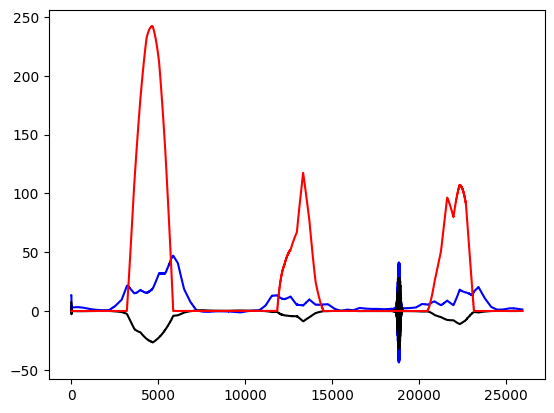

In [59]:
#plt.plot(q_cv, color= 'g')
plt.plot(q_ground, color= 'b')
plt.plot(q_air, color= 'black')
plt.plot(q_alpha, color= 'r')